In [1]:
import numpy as np
from gensim.models import KeyedVectors
from tqdm import tqdm
from itertools import chain
from collections import Counter, defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
import itertools
from scipy.special import comb
from sklearn.metrics.cluster import v_measure_score, homogeneity_score, completeness_score
from sklearn.cluster import AgglomerativeClustering,KMeans
from collections import defaultdict
import argparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [2]:
def load_raw_data(fi):
    """ Load raw data from file

    :param fi: data file name
    :type fi: str
    :return: a list of raw data from file
    :rtype: list
    """

    raw_data_strings = []
    with open(fi, "r") as fin:
        for line in fin:
            raw_data_strings.append(line.strip())
    return raw_data_strings
def read_synset(fp):
    '''
    读取同义词集
    '''
    data = load_raw_data(fp)
    output = []
    for line in data:
        items = line.split('\t')
        items = [item.split('(')[0].replace(' ', '_') for item in items]
        output.append(items)
    return output




def evaluate_clustering(cls_pred, cls_true):
    """ Evaluate clustering results

    :param cls_pred: a list of element lists representing model predicted clustering
    :type cls_pred: list
    :param cls_true: a list of element lists representing the ground truth clustering
    :type cls_true: list
    :return: a dictionary of clustering evaluation metrics
    :rtype: dict
    """
    # import pickle
    # pickle.dump({'pred':cls_pred,'true':cls_true},open('pred_true.pkl','wb'))

    vocab_pred = set(itertools.chain(*cls_pred))
    vocab_true = set(itertools.chain(*cls_true))
    assert (vocab_pred ==
            vocab_true), "Unmatched vocabulary during clustering evaluation"

    # Cluster number
    num_of_predict_clusters = len(cls_pred)

    # Cluster size histogram
    cluster_size2num_of_predicted_clusters = Counter(
        [len(cluster) for cluster in cls_pred])

    # Exact cluster prediction
    pred_cluster_set = set([frozenset(cluster) for cluster in cls_pred])
    gt_cluster_set = set([frozenset(cluster) for cluster in cls_true])
    num_of_exact_set_prediction = len(
        pred_cluster_set.intersection(gt_cluster_set))  # 计算cluster的重合

    # Clustering metrics
    word2rank = {}  # 单词index对应的 rank
    wordrank2gt_cluster = {}
    rank = 0
    for cid, cluster in enumerate(cls_true):
        for word in cluster:
            if word not in word2rank:
                word2rank[word] = rank
                rank += 1
            # 对词对应的rank给予聚类类别 cid是聚类类别
            wordrank2gt_cluster[word2rank[word]] = cid
    gt_cluster_vector = [ele[1] for ele in sorted(wordrank2gt_cluster.items())]

    wordrank2pred_cluster = {}
    for cid, cluster in enumerate(cls_pred):
        for word in cluster:
            wordrank2pred_cluster[word2rank[word]] = cid
    pred_cluster_vector = [ele[1]
                           for ele in sorted(wordrank2pred_cluster.items())]

    # print("pred_cluster_vector:", pred_cluster_vector)
    # print("gt_cluster_vector:", gt_cluster_vector)
    ARI = adjusted_rand_score(gt_cluster_vector, pred_cluster_vector)
    FMI = fowlkes_mallows_score(gt_cluster_vector, pred_cluster_vector)
    NMI = normalized_mutual_info_score(gt_cluster_vector, pred_cluster_vector)

    # Pair-based clustering metrics
    '''
    p: 0 0 1 1 1
    t: 0 0 0 1 1
    '''
    def pair_set(labels):
        S = set()
        cluster_ids = np.unique(labels)  # 聚类种类
        for cluster_id in cluster_ids:
            cluster = np.where(labels == cluster_id)[0]
            n = len(cluster)  # number of elements in this cluster
            if n >= 2:
                # 找出所有的cluster instance的排列组合
                for i in range(n):
                    for j in range(i + 1, n):
                        S.add((cluster[i], cluster[j]))
            # elif n > 0:
            #     S.add(cluster[0])

        return S

    F_S = pair_set(gt_cluster_vector)  # tp +fn
    F_K = pair_set(pred_cluster_vector)  # tp +fp
    # compute p r f1
    if len(F_K) == 0:
        pair_recall = 0
        pair_precision = 0
        pair_f1 = 0
    else:
        common_pairs = len(F_K & F_S)  # tp
        pair_recall = common_pairs / len(F_S)
        pair_precision = common_pairs / len(F_K)
        eps = 1e-6
        pair_f1 = 2 * pair_precision * pair_recall / \
            (pair_precision + pair_recall + eps)

    # KM matching
    mwm_jaccard = None #end2end_evaluation_matching(cls_true, cls_pred)
    eval = Evaluator(gt_cluster_vector)
    p, r, f = eval.calc_paired_f_measure(pred_cluster_vector)
    h, c, v = eval.calc_v_measure(pred_cluster_vector)
    print("precsion {} recall:{} f1:{}".format(p,r,f))
    print(h,c,v)
    print(ARI,FMI,NMI)
    metrics = {"ARI": ARI, "FMI": FMI, "NMI": NMI, "pair_recall": pair_recall, "pair_precision": pair_precision,
               "pair_f1": pair_f1, "predicted_clusters": cls_pred, "num_of_predicted_clusters": num_of_predict_clusters,
               "cluster_size2num_of_predicted_clusters": cluster_size2num_of_predicted_clusters,
               "num_of_exact_set_prediction": num_of_exact_set_prediction,
               "maximum_weighted_match_jaccard": mwm_jaccard,
               'feng_p': p,
               'feng_r': r,
               'feng_f': f,
               'homogeneity': h,
               'completeness': c,
               'v_measure_score': v, }

    return metrics


class Evaluator(object):
    def __init__(self, gt):
        self.gt = gt

    def calc_v_measure(self, preds):
        return homogeneity_score(self.gt, preds), completeness_score(self.gt, preds), v_measure_score(self.gt, preds)

    def calc_paired_f_measure(self, preds):
        pred_n_clusters = len(set(preds))
        gt_cluster_num = len(set(self.gt))

        gt_n = 0.0 # tp + fn 
        gt = np.array(self.gt)
        for cluster in range(gt_cluster_num):
            gt_n += comb(len(np.where(gt == cluster)
                             [0]), 2, exact=True)  # 计算排列数量

        pred_n = 0.0  # tp + tp
        pred_right_n = 0.0 # tp 
        preds = np.array(preds)
        max_cluster = -1
        for cluster in range(pred_n_clusters):
            indices = np.where(preds == cluster)[0]
            if len(indices) > max_cluster:
                max_cluster = len(indices)
            pred_n += comb(len(indices), 2, exact=True)  # 计算排序组合

            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    if self.gt[indices[i]] == self.gt[indices[j]]:
                        pred_right_n += 1

        if pred_n == 0:
            p = 0
            r = 0
            f1 = 0
        else:
            p = pred_right_n / pred_n
            r = pred_right_n / gt_n
            if p == 0 and r == 0:
                f1 = 0
            else:
                f1 = 2 * p * r / (p + r)
        # return pred_right_n, pred_n, gt_n, p, r, 2 * p * r / (p + r), max_cluster
        return p, r, f1

def map2index(synset,word2id):
    result = []
    for words in synset:
        result.append([word2id[w] for w in words])
    return result
def print_results(metric):
    keys = ['feng_p', 'feng_r', 'feng_f','homogeneity', 'completeness', 'v_measure_score','ARI', 'FMI', 'NMI']
    results = [metric[key] for key in keys]
    results = [ "{:.4f}".format(i) for i in results]
    print("|".join(results))

def print_cluster_quality(metric):
    res = []
    
    for k ,v in metric['cluster_size2num_of_predicted_clusters'].items():
        res.append((k,v))
    res.sort(key=lambda x:x[0])
    res = [ "{}:{}".format(k,v)for k,v in res]
    print(",".join(res))
    print("num_of_exact_set_prediction:{}".format(metric['num_of_exact_set_prediction']))

In [3]:
synset_file = "wiki_std_synset/test_label.txt"
# w2v_file = "./wiki_unique_std.txt.vec"
mw2v_file = "../best_multimodal_rank.txt.vec"

In [4]:
w2v_file = "wiki_visual2048.txt.vec"

In [5]:
word2vec = KeyedVectors.load_word2vec_format(w2v_file)
synset = read_synset(synset_file)
# synset = synset[1300:1500]+synset[3100:3200]
id2word = list(chain(*synset))

word_vecs=[]
for word in id2word:
    word_vecs.append(word2vec[word])
word_vecs = np.array(word_vecs)
word_vecs /= (word_vecs**2).sum(axis=1, keepdims=True)**0.5
word2id = {j: i for i, j in enumerate(id2word)}
num_words = word_vecs.shape[0]

/raid_sdb/home/chenguang/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


FileNotFoundError: [Errno 2] No such file or directory: 'wiki_visual2048.txt.vec'

In [5]:
multimodal2vec = KeyedVectors.load_word2vec_format(mw2v_file)
# multimodal2vec = KeyedVectors.load_word2vec_format('multimodal_rank.txt.vec')

In [10]:
multimodal2vec.wv.vectors.shape

/home/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(8509, 1024)

In [6]:
modal_vecs= []
for word in id2word:
    modal_vecs.append(multimodal2vec[word])
modal_vecs = np.array(modal_vecs)

In [7]:
clustering = KMeans(n_clusters=209).fit(word_vecs)

In [9]:
def batch_cos_sim(mat):
    above = mat.dot(mat.T)
    below = np.linalg.norm(mat,axis=1).reshape(-1,1)
    return above/(below**2)

In [10]:
distance=pairwise_distances(word_vecs,metric='cosine')

In [83]:
splits = np.split(word_vecs,indices_or_sections=2,axis=1)

In [84]:
distance=pairwise_distances(splits[1],metric='euclidean')

In [85]:
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
                                         compute_full_tree=True, distance_threshold=0.29).fit(distance)

In [8]:
distance=pairwise_distances(word_vecs,metric='l2')
# evalution metric
# clustering = AgglomerativeClustering(n_clusters=209,linkage='average',affinity='euclidean').fit(modal_vecs)
# clustering = AgglomerativeClustering(n_clusters=None,linkage='average',affinity='euclidean',distance_threshold=0.52).fit(word_vecs)
# clustering = KMeans(n_clusters=209,random_state=9).fit(word_vecs)
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
                                     compute_full_tree=True, distance_threshold=0.5).fit(distance)
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)

precsion 0.024886877828054297 recall:0.08168316831683169 f1:0.038150289017341035
0.696706616251616 0.7767910434271086 0.7345725401676756
0.03289992127608252 0.045087016207655456 0.7345725401676756
0.0249|0.0817|0.0382|0.6967|0.7768|0.7346|0.0329|0.0451|0.7346


In [150]:
for clusters in metric["predicted_clusters"]:
    words = [id2word[i]for i in clusters]
    if word_exists(test_cands,words):
        print(words)

['harrystruman', 'franklindelanoroosevelt', 'franklinroosevelt', 'presidentfranklindelanoroosevelt']
['harrytruman', 'presidentharrytruman']
['presidenttruman', 'truman', 'fdr', 'presidentroosevelt']
['esotericbuddhism', 'tantricbuddhism', 'vajrayanabuddhism']
['vajrayana']
['bible', 'christianbible', 'thebible']
['holybible']
['daoism', 'taoism']
['taoist']
['barackobama']
['obama', 'presidentobama']
['christ', 'jesuschrist', 'jesus']
['gautamabuddha']
['shakyamuni']
['billclinton', 'presidentbillclinton', 'presidentclinton', 'jimmycarter', 'presidentjimmycarter']
['zenbuddhism']
['zen']
['presidentcarter']


In [15]:
#适合kmeans的点
for i in range(954,955):
    print("radom_state=",i)
    clustering = KMeans(n_clusters=209,random_state=i).fit(word_vecs)
    labels = clustering.labels_
    pred_dict = defaultdict(list)
    for idx,l in enumerate(labels):
        pred_dict[l].append(idx)
    pred = [v for k,v in pred_dict.items()]
    # pred = map2index([v for k,v in class2word.items()],word2id)
    ground_truth = map2index(synset,word2id)
    # for i in pred:
    #     print([id2word[j]for j in i])
    # print(len(pred))
    metric = evaluate_clustering(pred,ground_truth)

radom_state= 954


ValueError: n_samples=133 should be >= n_clusters=209

In [202]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
#     print(linkage_matrix)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

In [ ]:
r = pl

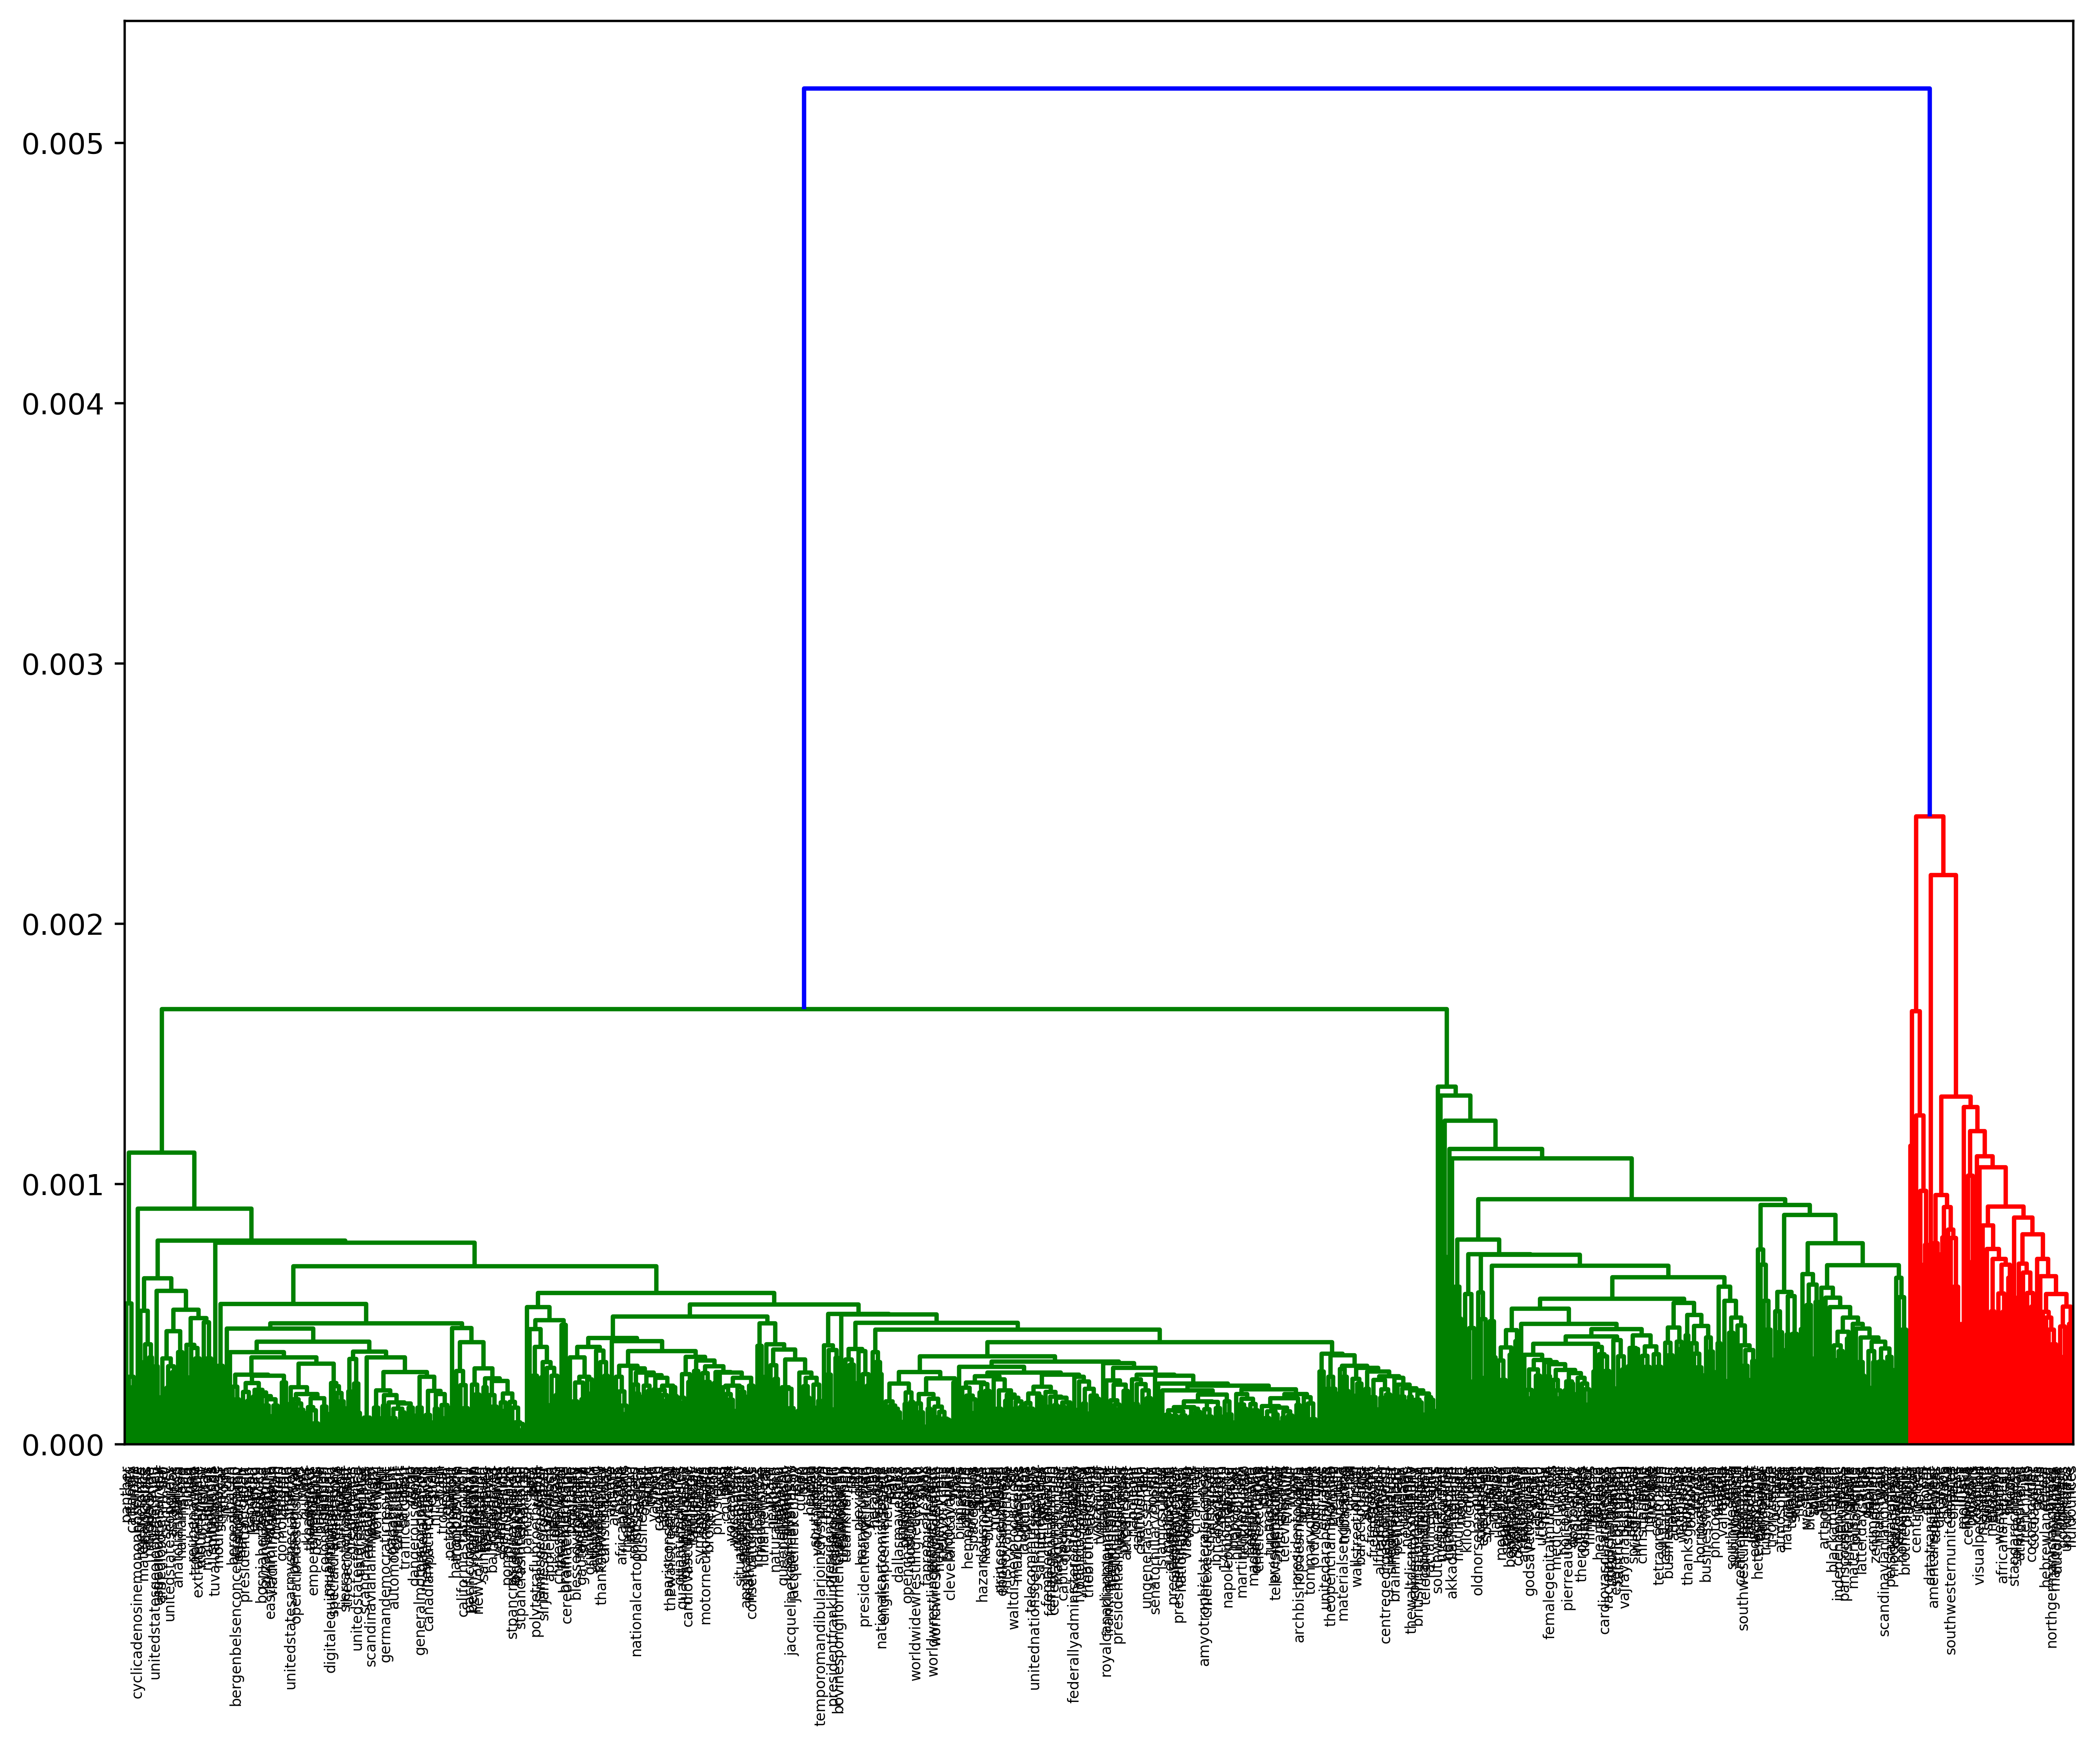

In [203]:
plt.figure(figsize=(12,9),dpi=400)
a=plot_dendrogram(clustering,truncate_mode='level',labels=id2word)
plt.savefig("1.jpg")

In [41]:
len(id2word)

211

# MSI
954

In [217]:
visual2vec = KeyedVectors.load_word2vec_format("wiki_visual2048.txt.vec")

/home/peter/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [218]:
visual_vecs=[]
for word in id2word:
    visual_vecs.append(visual2vec[word])
visual_vecs = np.array(visual_vecs)

In [239]:
visual_dis= pairwise_distances(normalize(visual_vecs))
# visual_dis =pairwise_distances(normalize(visual_vecs),metric='cosine')

In [313]:
visual_vecs

array([[0.40445748, 0.51309454, 0.49346474, ..., 0.44430566, 0.6080661 ,
        0.5414891 ],
       [0.38325295, 0.5065807 , 0.49590844, ..., 0.41540945, 0.5214722 ,
        0.51621306],
       [0.4541341 , 0.52955174, 0.4260951 , ..., 0.42276448, 0.59368783,
        0.48180225],
       ...,
       [0.29688033, 0.49409312, 0.5293951 , ..., 0.37938103, 0.4880436 ,
        0.4959135 ],
       [0.32299408, 0.5090431 , 0.5214745 , ..., 0.37777406, 0.43919772,
        0.48728034],
       [0.28617373, 0.5161189 , 0.5605003 , ..., 0.33474618, 0.45984623,
        0.5061052 ]], dtype=float32)

In [269]:
from sklearn.cluster import ward_tree

In [268]:
# distance = weight_distance_calculation(word_vecs,visual_vecs,alpha=0.8,not_norm=False)
# distance = weight_distance_calculation(word_vecs,visual_vecs,alpha=0.9,not_norm=False,metric="l2")
# distance = weight_distance_calculation(splits[0],splits[1],alpha=0.9)
# distance = pairwise_distances(normalize(modal_vecs),metric='l2')
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
                                     compute_full_tree=True, distance_threshold=0.1).fit(visual_dis)
# clustering = KMeans(n_clusters=209,random_state=954,precompute_distances=True).fit(visual_dis)
# clustering = KMeans(n_clusters=209,random_state=954).fit(visual_vecs)
# clustering = AgglomerativeClustering(n_clusters=209,linkage='complete',affinity='l2').fit(visual_vecs)
# evalution metri
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)

precsion 0.3867403314917127 recall:0.2599009900990099 f1:0.31088082901554404
0.9475049503602734 0.8563823299589499 0.8996421294057538
0.30891340561513403 0.31703973736097407 0.899642129405754
0.3867|0.2599|0.3109|0.9475|0.8564|0.8996|0.3089|0.3170|0.8996


In [209]:
def weight_distance_calculation(w,v,alpha,not_norm=False,metric="l2"):
    if not_norm:
        visual_dis =pairwise_distances(v,metric=metric)
        word_dis = pairwise_distances(w,metric=metric)
    else:
        visual_dis =pairwise_distances(normalize(v),metric=metric)
        word_dis = pairwise_distances(normalize(w),metric=metric)
    return word_dis*alpha + visual_dis*(1-alpha)

In [20]:
w2v_cnn = np.concatenate([word_vecs,visual_vecs],axis=1)

In [21]:
w2v_cnn_norm = np.concatenate([normalize(word_vecs),normalize(visual_vecs)],axis=1)


In [22]:
distance = pairwise_distances(w2v_cnn_norm)

In [18]:
# distance = pairwise_distances(normalize(a[1]))*0.5
# a = np.split(modal_vecs,2,axis=1)


metric|alpha| threshold| best_f1
---|---|---|---
l2 | 0.1| 0.1 | 0.19 | 0.3188
l2 | 0.2 | 0.21 | 0.6325
l2 | 0.3 | 0.27 | 0.6458
l2 | 0.4 | 0.32 | 0.6393
l2 | 0.5 | 0.34 | 0.6266
l2 | 0.6 | 0.39 | 0.6325
l2 | 0.7 | 0.43 | 0.61009
l2 | 0.8 | 0.51 | 0.6025
l2 | 0.9 | 0.56 | 0.5955

In [350]:
# distance = weight_distance_calculation(word_vecs,visual_vecs,alpha=0.8,not_norm=False)
distance = weight_distance_calculation(word_vecs,visual_vecs,alpha=0.9,not_norm=False,metric="l2")
# distance = weight_distance_calculation(splits[0],splits[1],alpha=0.9)
# distance = pairwise_distances(normalize(modal_vecs),metric='l2')
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
                                     compute_full_tree=True, distance_threshold=0.56).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954,precompute_distances=True).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954).fit(w2v_cnn_norm)
# clustering = AgglomerativeClustering(n_clusters=209,linkage='complete',affinity='l2').fit(w2v_cnn_norm)
# evalution metri
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)

precsion 0.5517970401691332 recall:0.6460396039603961 f1:0.5952109464082098
0.946589211873509 0.9323629898518301 0.9394222449442422
0.5936586543154825 0.5970617566863462 0.9394222449442421
0.5518|0.6460|0.5952|0.9466|0.9324|0.9394|0.5937|0.5971|0.9394


#### from scipy.cluster.hierarchy import linkage

In [198]:
modal_vecs

array([[ 1.1234483e-03, -3.1047624e-01,  9.1412367e-04, ...,
         3.7088150e-05, -2.2316573e-03, -2.4223782e-03],
       [ 1.3135535e-03, -2.7101317e-01,  1.1248821e-03, ...,
         5.0839979e-05, -1.1377834e-02, -1.2595157e-02],
       [ 9.8231668e-04, -3.0783811e-01,  7.8284350e-04, ...,
         2.9303150e-05, -7.9644062e-03, -9.3379198e-03],
       ...,
       [ 2.6092563e-02, -1.0159099e-01,  3.5653684e-02, ...,
         2.0162887e-03,  2.1884052e-02, -2.2236006e-02],
       [ 2.3139654e-02, -1.0560686e-01,  3.0922659e-02, ...,
         2.1388051e-03,  8.4838653e-03, -1.6976617e-02],
       [ 2.9855261e-02, -8.9915320e-02,  4.1104659e-02, ...,
         2.7944222e-03,  1.5164340e-02, -2.3038665e-02]], dtype=float32)

In [210]:
from scipy.cluster.hierarchy import linkage
m=linkage(modal_vecs[:100],method='average')

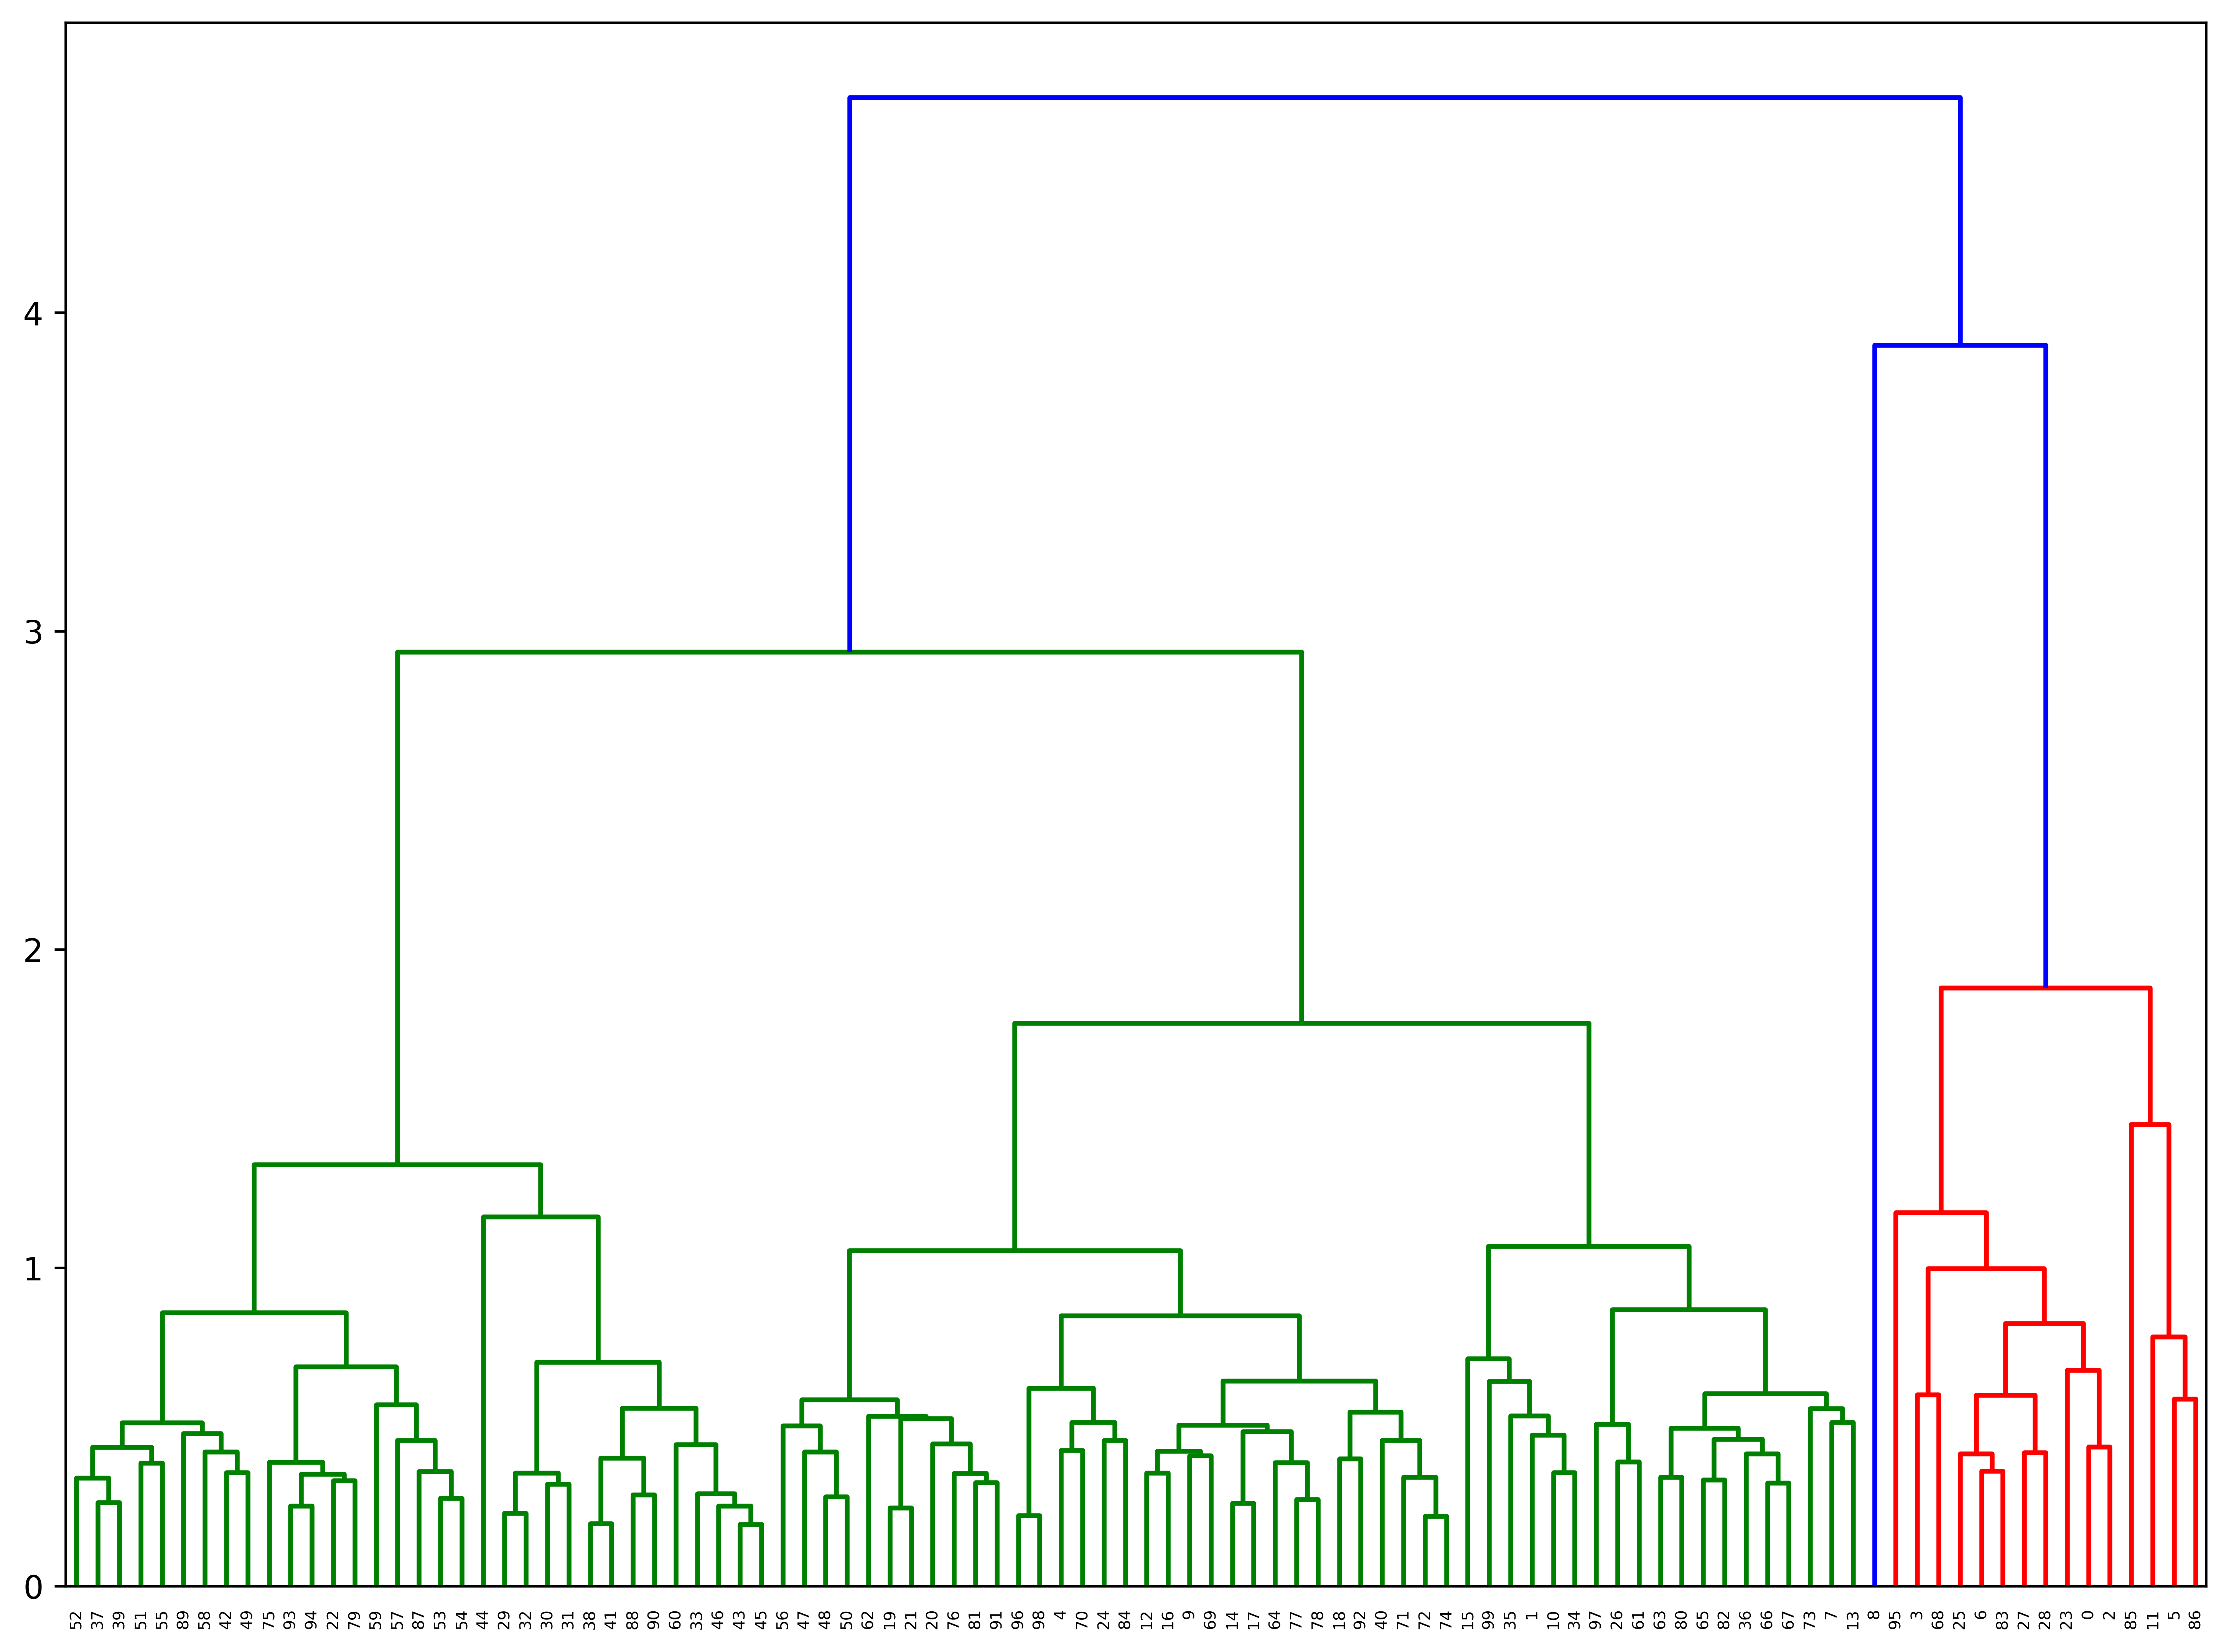

In [213]:
plt.figure(figsize=(12,9),dpi=600)
dendrogram(m)
plt.savefig("1.png")
plt.show()


In [28]:
word_vecs.shape

(133, 50)

In [45]:
clustering.children_

(675, 2)

In [39]:
def plot_dendrogram(distance_matrix, labels, ):
    tree_dict = {}
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            key = tuple(sorted([i,j]))
            if labels[i]==labels[j] and i!=j:
                if key not in tree_dict:
                    tree_dict[key]=[distance_matrix[i][j],labels[i]]
    linkage = []
    for k,v in tree_dict.items():
        linkage.append(list(k)+v)
    linkage= np.array(linkage)
    dendrogram(linkage)
    return linkage
                   

In [ ]:
plot_dendrogram(distance,clustering.labels_)

In [117]:
metric.keys()

dict_keys(['ARI', 'FMI', 'NMI', 'pair_recall', 'pair_precision', 'pair_f1', 'predicted_clusters', 'num_of_predicted_clusters', 'cluster_size2num_of_predicted_clusters', 'num_of_exact_set_prediction', 'maximum_weighted_match_jaccard', 'feng_p', 'feng_r', 'feng_f', 'homogeneity', 'completeness', 'v_measure_score'])

# TrimSyn

In [6]:
multi_vec = KeyedVectors.load_word2vec_format('best_multimodal_rank.txt.vec')
# multi_vec = KeyedVectors.load_word2vec_format('best_multimodal_rank.txt.vec_bk')
# multi_vec = KeyedVectors.load_word2vec_format('multimodal_rank.txt.vec') #中文的结果



FileNotFoundError: [Errno 2] No such file or directory: 'best_multimodal_rank.txt.vec'

In [280]:
vecs=[]
for word in id2word:
    vecs.append(multi_vec[word])
vecs = np.array(vecs)

In [12]:
vecs = modal_vecs

In [281]:
splits = np.split(vecs,indices_or_sections=2,axis=1)
# splits = np.split(modal_vecs,indices_or_sections=2,axis=1)

def construct_dis_mat(tag,image,alpha,clamp=False,norm=False):
    if norm:
        tag = normalize(tag)
        image = normalize(image)
    tag_sim = pairwise_distances(tag,metric='cosine')
    image_sim = pairwise_distances(image,metric='cosine')
    if clamp:
        tag_sim[tag_sim<0]=0
        image_sim[image_sim<0]=0
    return alpha*tag_sim +(1-alpha) * image_sim

In [138]:
distance = construct_dis_mat(splits[1],splits[0],alpha=0.6,clamp=False,norm=True)

In [300]:
single_text_distance = pairwise_distances(normalize(splits[0]),metric="cosine")
single_visual_distance = pairwise_distances(normalize(splits[1]),metric="cosine")
singe_distance=pairwise_distances(vecs,metric="l2")

In [301]:
single_visual_distance*0.6

array([[0.        , 0.0005756 , 0.00012207, ..., 0.00032222, 0.00058889,
        0.00046754],
       [0.0005756 , 0.        , 0.00047982, ..., 0.00072169, 0.00154686,
        0.00122559],
       [0.00012207, 0.00047982, 0.        , ..., 0.00036162, 0.00070977,
        0.0005343 ],
       ...,
       [0.00032222, 0.00072169, 0.00036162, ..., 0.        , 0.0003022 ,
        0.00019932],
       [0.00058889, 0.00154686, 0.00070977, ..., 0.0003022 , 0.        ,
        0.00010002],
       [0.00046754, 0.00122559, 0.0005343 , ..., 0.00019932, 0.00010002,
        0.        ]], dtype=float32)

# hac

metric|alpha|threshold|best_f1
---|---|---|---
cosine | 0.1 | -   |0
cosine | 0.2 | 0.09| 0.66377
cosine | 0.3 |0.14 | 0.6873
cosine | 0.4 |0.19 | 0.6632
cosine | 0.5 |0.21 | 0.6626
cosine | 0.6 |0.28 | 0.6781
cosine | 0.7 | 0.29| 0.6794
cosine | 0.8 | 0.33| 0.6772
cosine | 0.9 | 0.37| 0.6754

In [348]:
distance = construct_dis_mat(splits[0],splits[1],alpha=0.7,clamp=False,norm=True)
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
                                     compute_full_tree=True, distance_threshold=0.29).fit(single_visual_distance)
# clustering = KMeans(n_clusters=209,random_state=954,precompute_distances=True).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954).fit(w2v_cnn_norm)
# clustering = AgglomerativeClustering(n_clusters=209,linkage='average',affinity='cosine').fit(vecs)
# evalution metri
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)

precsion 0.003541529695375849 recall:1.0 f1:0.007058063050865224
9.848065089707567e-17 1.0 1.9696130179415133e-16
0.0 0.05951075277104004 1.9696130179415133e-16
0.0035|1.0000|0.0071|0.0000|1.0000|0.0000|0.0000|0.0595|0.0000


# kmean 找到最佳的$\mu$

metric | aplph | precision| recall | f1 | homogeneity | comleteness| v measure score | ARI |FMI |NMI
---|---|---|---|---|---|---|---|---|---|---
cosine |0   |0.0309|0.0644|0.0418|0.7343|0.7813|0.7571|0.0372|0.0446|0.7571
cosine |0.1 | 0.5786|0.6832|0.6266|0.9298|0.9412|0.9354|0.6251|0.6287|0.9354
cosine | 0.2|0.5998|0.6807|0.6377|0.9332|0.9416|0.9374|0.6363|0.6390|0.9374
cosine | 0.3|0.6085|0.7116|0.6560|0.9338|0.9448|0.9393|**0.6547**|0.6580|0.9393
cosine |0.4| 0.5949|0.6906|0.6392|0.9317|0.9416|0.9366|0.6378|0.6410|0.9366
cosine | 0.5|0.5530|0.6646|0.6037|0.9251|0.9371|0.9310|0.6022|0.6063|0.9310
cosine |0.6|0.5833|0.6844|0.6298|0.9298|0.9415|0.9356|0.6284|0.6319|0.9356
cosine | 0.7|0.5824|0.6869|0.6303|0.9294|0.9404|0.9349|0.6289|0.6325|0.9349
cosine |0.8|0.5744|0.6881|0.6261|0.9295|0.9414|0.9354|0.6247|0.6287|0.9354
cosine | 0.9|0.5993|0.6832|0.6385|0.9317|0.9404|0.9360|0.6372|0.6399|0.9360
cosine |1.0|0.5734|0.7054|0.6326|0.9308|0.9446|0.9376|0.6312|0.6360|0.9376

In [ ]:
# for c in [10,20,40,60,80,100,120,140,160,180,190,200,209,215,220,225,230,235,240,260,280,300,320,400]:
#     print(c)
    # kmeanas on best results
distance = construct_dis_mat(splits[0],splits[1],alpha=0.3,clamp=False,norm=True)
clustering = KMeans(n_clusters=c,
                    n_init=50,
                    tol=1e4,
                    random_state=954,
                    precompute_distances=True,
                    n_jobs=4,
                   ).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954,n_init=50,
#                     tol=1e4,n_jobs=4,
#                     algorithm="auto" #full elkan
#                    ).fit(vecs)
# clustering = AgglomerativeClustering(n_clusters=209,linkage='ward',affinity='euclidean').fit(normalize(vecs))
# AgglomerativeClustering(n_clusters=len(synset), affinity='euclidean', linkage='average'
# evalution metri
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)
print_cluster_quality(metric)
print(metric['cluster_size2num_of_predicted_clusters'])

In [362]:
metric.keys()

dict_keys(['ARI', 'FMI', 'NMI', 'pair_recall', 'pair_precision', 'pair_f1', 'predicted_clusters', 'num_of_predicted_clusters', 'cluster_size2num_of_predicted_clusters', 'num_of_exact_set_prediction', 'maximum_weighted_match_jaccard', 'feng_p', 'feng_r', 'feng_f', 'homogeneity', 'completeness', 'v_measure_score'])

metric | K | num of exact set | cluster size |
--- |---| ---|---
cosine | 10 | 0 | 39:1,41:1,44:1,47:1,56:1,67:1,75:1,76:1,111:1,120:1
cosine | 20 | 0 |19:1,20:1,21:1,24:3,25:1,28:1,31:3,33:1,34:1,37:1,43:1,44:1,47:1,49:1,51:1,60:1
cosine | 40 | 0 |6:1,7:1,9:3,10:1,12:1,13:4,14:5,15:2,16:2,17:3,18:3,20:2,21:2,22:4,24:2,25:3,32:1
cosine | 60 | 0 |6:4,7:2,8:7,9:6,10:9,11:6,12:8,13:6,14:2,15:2,16:2,17:3,18:1,19:1,20:1
cosine | 80 |1 |3:1,4:7,5:9,6:7,7:4,8:12,9:13,10:7,11:10,12:3,13:3,14:1,15:1,16:1,17:1
cosine | 100|11 | 3:8,4:13,5:14,6:16,7:10,8:13,9:10,10:11,11:2,12:2,14:1
cosine | 120| 27|1:1,2:1,3:23,4:25,5:17,6:20,7:8,8:7,9:6,10:5,11:4,12:1,13:1,14:1
cosine |140 | 42 |1:1,2:3,3:43,4:30,5:21,6:16,7:9,8:8,9:3,10:3,11:2,13:1
cosine |160 |49 |1:2,2:12,3:60,4:37,5:14,6:15,7:10,8:4,9:1,10:4,11:1
cosine | 180|59 |1:7,2:21,3:77,4:33,5:17,6:12,7:6,8:2,9:1,10:4
cosine | 190 |61 |1:10,2:23,3:82,4:40,5:13,6:13,7:6,8:1,10:1,11:1
cosine |200| 85 |1:11,2:25,3:96,4:36,5:16,6:11,7:4,9:1 
cosine |209 | 72 |1:19,2:31,3:87,4:45,5:15,6:10,8:1,11:1
cosine |215| 72 |1:21,2:34,3:92,4:43,5:13,6:11,8:1 
cosine |220 |73 |1:23,2:38,3:94,4:40,5:15,6:10
cosine |225 |72 |1:26,2:48,3:94,4:34,5:15,6:3,7:1,8:2,9:1,11:1
cosine |230 |78 | 1:29,2:45,3:99,4:34,5:14,6:9
cosine |235 |77 |1:31,2:53,3:96,4:33,5:13,6:9
cosine |240 |78 | 1:33,2:57,3:97,4:34,5:12,6:7
cosine |260 | 79|1:53,2:65,3:97,4:28,5:12,6:5
cosine |280 |73 |1:79,2:66,3:94,4:27,5:9,6:5
cosine |300 | 74 |1:98,2:75,3:96,4:20,5:6,6:5
cosine |320 | 73 |1:119,2:85,3:89,4:20,5:2,6:5
cosine |400 | 51 | 1:219,2:108,3:57,4:11,5:4,6:1

metric | K | precision| recall | f1 | homogeneity | comleteness| v measure score | ARI |FMI |NMI
---|---|---|---|---|---|---|---|---|---|---
cosine |10  | 0.0205|0.6646|0.0398|0.3514|0.8397|0.4955|0.0331|0.1167|0.4955
cosine |20  | 0.0431|0.6597|0.0808|0.4844|0.8762|0.6239|0.0747|0.1685|0.6239
cosine |40  | 0.0905|0.6733|0.1596|0.6155|0.9015|0.7315|0.1543|0.2468|0.7315
cosine | 60 | 0.1540|0.7240|0.2540|0.7059|0.9267|0.8013|0.2496|0.3339|0.8013
cosine |80  | 0.2089|0.7438|0.3262|0.7600|0.9362|0.8390|0.3224|0.3942|0.8390
cosine | 100| 0.2562|0.7116|0.3768|0.7965|0.9333|0.8595|0.3735|0.4270|0.8595
cosine |120 | 0.3021|0.7290|0.4271|0.8272|0.9377|0.8790|0.4242|0.4692|0.8790
cosine | 140| 0.3711|0.7376|0.4938|0.8605|0.9430|0.8999|0.4914|0.5232|0.8999
cosine |160 | 0.4257|0.7228|0.5358|0.8839|0.9431|0.9125|0.5337|0.5547|0.9125
cosine |180 | 0.4791|0.7104|0.5723|0.9038|0.9431|0.9230|0.5705|0.5834|0.9230
cosine |190 | 0.5138|0.6918|0.5897|0.9127|0.9408|0.9265|0.5880|0.5962|0.9265
cosine |200 | 0.5924|0.7141|0.6476|0.9296|0.9462|0.9379|0.6462|0.6504|0.9379
cosine |209 | 0.6085|0.7116|0.6560|0.9338|0.9448|0.9393|0.6547|0.6580|0.9393
cosine |215 | 0.6207|0.6844|0.6510|0.9358|0.9409|0.9383|0.6497|0.6517|0.9383 
cosine |220 | 0.6407|0.6819|0.6607|0.9400|0.9410|0.9405|0.6594|0.6610|0.9405
cosine |225 | 0.5975|0.6634|0.6287|0.9381|0.9386|0.9383|0.6274|0.6296|0.9383
cosine |230 | 0.6626|0.6733|0.6679|0.9461|0.9403|0.9432|0.6667|0.6679|0.9432 
cosine |235 | 0.6716|0.6683|0.6700|0.9485|0.9395|0.9440|0.6688|0.6700|0.9440
cosine |240 | 0.6885|0.6621|0.6751|0.9516|0.9386|0.9450|0.6739|0.6752|0.9450
cosine |245 | 0.6967|0.6597|0.6777|0.9541|0.9385|0.9462|0.6766 |0.6779|0.9462
cosine |260 | 0.7135|0.6349|0.6719|0.9589|0.9346|0.9466|0.6708|0.6730|0.9466
cosine |280 | 0.7319|0.6114|0.6662|0.9630|0.9290|0.9457|0.6651|0.6689|0.9457
cosine |300 | 0.7718|0.5903|0.6690|0.9712|0.9260|0.9480|0.6680|0.6750|0.9480
cosine |320 | 0.7919|0.5557|0.6531|0.9757|0.9202|0.9472|0.6521|0.6634|0.9472
cosine |400 | 0.8300|0.4109|0.5497|0.9857|0.8944|0.9378|0.5486|0.5840|0.9378

 随着k增大聚类指标看似升高，但是实际上聚类的效果越来越差,可以观察num_of_exact_set_prediction，以及聚类的变化

In [119]:
for clusters in metric["predicted_clusters"]:
    words = [id2word[i]for i in clusters]
    if word_exists(test_cands,words):
        print(words)

NameError: name 'test_cands' is not defined

In [281]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def plot_embedding(data, label, title):
    
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
 
    fig = plt.figure(figsize=(12,9))
    
    plt.axis([0, 1.1, 0, 1.1])
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1_r(label[i]%10),
                 fontdict={'weight': 'bold', 'size': 12})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
#     return fig

In [275]:
tsne = TSNE(n_components=2,init="pca",random_state=0)
results = tsne.fit_transform(word_vecs)

In [267]:
word2cluster={}
for idx,ws in enumerate(synset):
    for w in ws:
        word2cluster[w]=idx

In [268]:
label = [word2cluster[w]for w in id2word]

/home/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


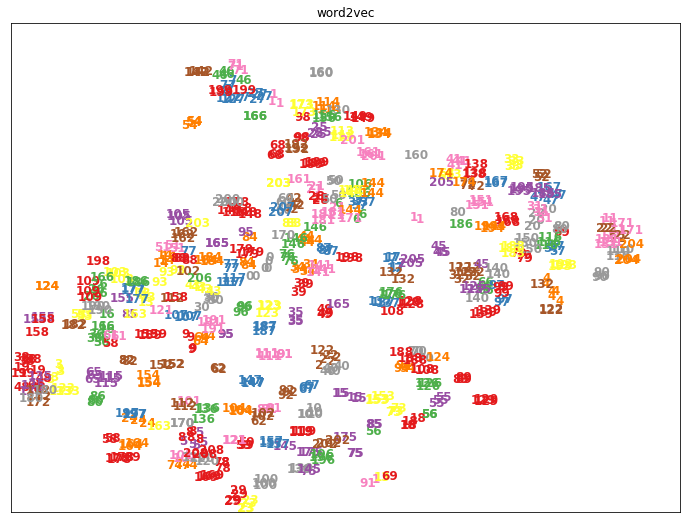

In [282]:
plot_embedding(results,label,"word2vec")
plt.savefig("test1.png")

In [92]:
tsne = TSNE(n_components=2,init="pca",random_state=0)
results = tsne.fit_transform(visual_vecs)

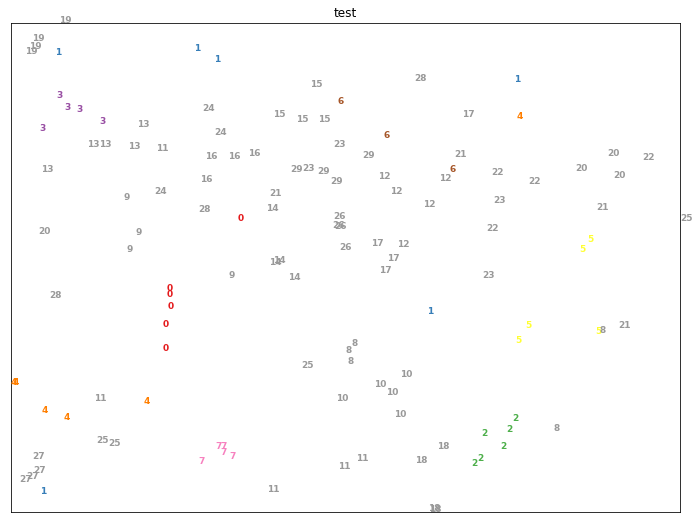

In [93]:
plot_embedding(results,label,"test")

In [270]:
a=np.split(modal_vecs,2,axis=1)

In [271]:
tsne = TSNE(n_components=2,init="pca",random_state=0)
results = tsne.fit_transform(a[0])

In [283]:
distance = weight_distance_calculation(a[0],a[1],alpha=0.5,not_norm=False)
tsne = TSNE(n_components=2,metric="precomputed",random_state=0)
results = tsne.fit_transform(distance)

/home/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


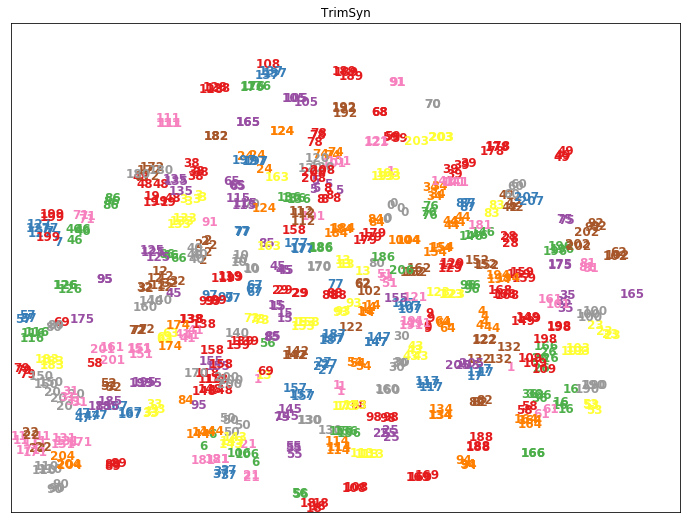

In [285]:
plot_embedding(results,label,"TrimSyn")
plt.savefig("test2.png")

In [299]:
a=np.random.randint(0,100,[10])

In [300]:
b=100-a

In [301]:
def cal(vec):
    v =[]
    for i in vec:
        new = []
        for j in vec:
            new.append(np.sqrt((i-j)**2))
        v.append(new)
    return np.array(v)

In [302]:
cal(a)

array([[ 0., 37., 58., 81., 84., 89., 69., 14., 23., 76.],
       [37.,  0., 21., 44., 47., 52., 32., 23., 14., 39.],
       [58., 21.,  0., 23., 26., 31., 11., 44., 35., 18.],
       [81., 44., 23.,  0.,  3.,  8., 12., 67., 58.,  5.],
       [84., 47., 26.,  3.,  0.,  5., 15., 70., 61.,  8.],
       [89., 52., 31.,  8.,  5.,  0., 20., 75., 66., 13.],
       [69., 32., 11., 12., 15., 20.,  0., 55., 46.,  7.],
       [14., 23., 44., 67., 70., 75., 55.,  0.,  9., 62.],
       [23., 14., 35., 58., 61., 66., 46.,  9.,  0., 53.],
       [76., 39., 18.,  5.,  8., 13.,  7., 62., 53.,  0.]])

In [303]:
cal(b)

array([[ 0., 37., 58., 81., 84., 89., 69., 14., 23., 76.],
       [37.,  0., 21., 44., 47., 52., 32., 23., 14., 39.],
       [58., 21.,  0., 23., 26., 31., 11., 44., 35., 18.],
       [81., 44., 23.,  0.,  3.,  8., 12., 67., 58.,  5.],
       [84., 47., 26.,  3.,  0.,  5., 15., 70., 61.,  8.],
       [89., 52., 31.,  8.,  5.,  0., 20., 75., 66., 13.],
       [69., 32., 11., 12., 15., 20.,  0., 55., 46.,  7.],
       [14., 23., 44., 67., 70., 75., 55.,  0.,  9., 62.],
       [23., 14., 35., 58., 61., 66., 46.,  9.,  0., 53.],
       [76., 39., 18.,  5.,  8., 13.,  7., 62., 53.,  0.]])

## 进一步分析

In [5]:
synset_file = "wiki_std_synset/train_label.txt"
multi_vec = KeyedVectors.load_word2vec_format('best_multimodal_rank.txt.vec')

In [35]:

synset = read_synset(synset_file)
synset = synset[1300:1500]+synset[3100:3200]

id2word = list(chain(*synset))
vecs=[]
for word in id2word:
    vecs.append(multi_vec[word])
vecs = np.array(vecs)

# splits = np.split(vecs,indices_or_sections=2,axis=1)

In [37]:
word2id = {j: i for i, j in enumerate(id2word)}
splits = np.split(vecs,indices_or_sections=2,axis=1)

In [38]:
distance = construct_dis_mat(splits[0],splits[1],alpha=0.6,clamp=False,norm=True)
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
                                     compute_full_tree=True, distance_threshold=0.16).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954,precompute_distances=True).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954).fit(w2v_cnn_norm)
# clustering = AgglomerativeClustering(n_clusters=209,linkage='average',affinity='cosine').fit(vecs)
# evalution metri
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)

precsion 0.7696969696969697 recall:0.42333333333333334 f1:0.546236559139785
0.9904230456615121 0.933919110520246 0.9613415232541282
0.5456983159900074 0.5708225502188783 0.9613415232541281
0.7697|0.4233|0.5462|0.9904|0.9339|0.9613|0.5457|0.5708|0.9613


In [118]:
cands =["saloon","sedan","automotive","car"]
def word_exists(cands,words):
    for c in cands:
        if c in words:
            return True
    return False

In [132]:
for clusters in metric["predicted_clusters"]:
    words = [id2word[i]for i in clusters]
    if word_exists(test_cands,words):
        print(words)

['harrystruman', 'harrytruman', 'presidentharrytruman', 'presidenttruman', 'truman', 'fdr', 'franklindelanoroosevelt', 'franklinroosevelt', 'presidentfranklindelanoroosevelt', 'presidentroosevelt']
['esotericbuddhism', 'tantricbuddhism', 'vajrayanabuddhism', 'vajrayana', 'taoist', 'zenbuddhism', 'zen']
['bible', 'christianbible', 'holybible', 'thebible']
['daoism', 'taoism']
['barackobama', 'obama', 'hillaryclinton', 'senatorhillaryclinton']
['presidentobama', 'billclinton', 'presidentbillclinton', 'presidentclinton', 'jimmycarter', 'presidentcarter', 'presidentjimmycarter']
['christ', 'jesuschrist', 'jesus']
['gautamabuddha']
['shakyamuni']


In [54]:
w2v_file = "./wiki_unique_std.txt.vec"
word2vec = KeyedVectors.load_word2vec_format(w2v_file)
word_vecs=[]
for word in id2word:
    word_vecs.append(multi_vec[word])
word_vecs = np.array(word_vecs)
word_vecs_norm = normalize(word_vecs)

/home/peter/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [57]:
distance =pairwise_distances(normalize(word_vecs),metric="l2")
# clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average',
#                                      compute_full_tree=True, distance_threshold=0.2).fit(distance)
# clustering = KMeans(n_clusters=209,random_state=954,precompute_distances=True).fit(distance)
# clustering = KMeans(n_clusters=len(synset),random_state=954).fit(word_vecs)
clustering = AgglomerativeClustering(n_clusters=len(synset),linkage='average',affinity='cosine').fit(word_vecs_norm)
# evalution metri
labels = clustering.labels_
pred_dict = defaultdict(list)
for idx,l in enumerate(labels):
    pred_dict[l].append(idx)
pred = [v for k,v in pred_dict.items()]
# pred = map2index([v for k,v in class2word.items()],word2id)
ground_truth = map2index(synset,word2id)
# for i in pred:
#     print([id2word[j]for j in i])
# print(len(pred))
metric = evaluate_clustering(pred,ground_truth)
print_results(metric)

precsion 0.033004552352048556 recall:0.29 f1:0.05926430517711171
0.8021894042750113 0.9028870073687415 0.8495647299120643
0.05643575424092273 0.09783312415585062 0.8495647299120644
0.0330|0.2900|0.0593|0.8022|0.9029|0.8496|0.0564|0.0978|0.8496


In [120]:
test_cands = ["daoism","taoism"  ,"taoist","esotericbuddhism","tantricbuddhism","vajrayanabuddhism","vajrayana",
        "bible","christianbible","holybible","thebible","gautamabuddha","shakyamuni",
        "christ","jesuschrist","jesus",
        "zenbuddhism","zen",
        "barackobama","obama","presidentobama",
        "harrystruman","harrytruman","presidentharrytruman","presidenttruman","truman",
        "billclinton","presidentbillclinton","presidentclinton",
        "jimmycarter","presidentcarter","presidentjimmycarter"]